In [1]:
reset -fs

In [2]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import Model

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [7]:
train_generator = datagen.flow_from_directory(
        'drive/MyDrive/human_1/train',  
        target_size=(224, 224), 
        batch_size=32,
        seed=11,
        shuffle=False,
        color_mode='rgb',
        class_mode='binary') 

Found 4352 images belonging to 2 classes.


In [8]:
val_generator = datagen.flow_from_directory(
        'drive/MyDrive/human_1/val',  
        target_size=(224, 224), 
        batch_size=32,
        seed=11,
        shuffle=False,
        color_mode='rgb',
        class_mode='binary') 

Found 1536 images belonging to 2 classes.


In [9]:
test_generator = datagen.flow_from_directory(
        'drive/MyDrive/human_1/test',  
        target_size=(224, 224), 
        batch_size=32,
        seed=11,
        shuffle=False,
        color_mode='rgb',
        class_mode='binary') 

Found 1536 images belonging to 2 classes.


In [ ]:
images, labels = next(train_generator)
print(images.shape)
print(labels.shape)

(32, 224, 224, 3)
(32,)


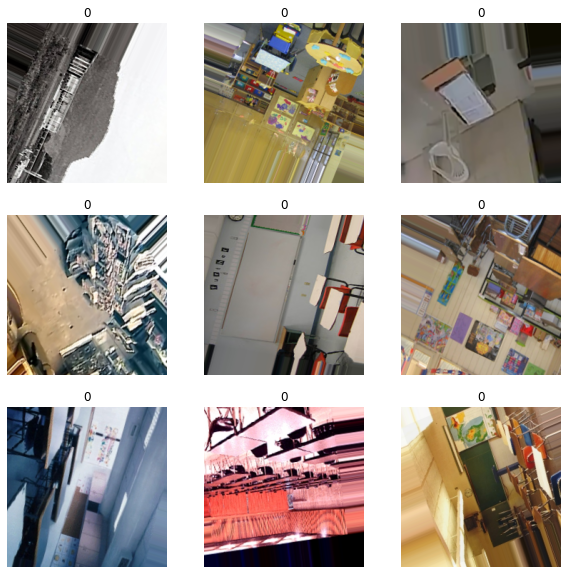

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(int(labels[i]))
    plt.axis("off")

In [16]:
with tf.device('/device:GPU:0'):
  model = keras.Sequential()

  model.add(Conv2D(64, (3,3),input_shape=(224,224,3),activation='relu'))
  model.add(MaxPool2D((2,2)))

  model.add(Conv2D(128, (3,3),activation='relu'))
  model.add(MaxPool2D((2,2)))

  model.add(Dropout(0.05))

  model.add(Conv2D(256, (3,3),activation='relu'))
  model.add(MaxPool2D((2,2)))

  model.add(Dropout(0.05))

  model.add(Conv2D(512, (3,3),activation='relu'))
  model.add(GlobalAveragePooling2D())
  #model.add(Flatten())

  model.add(Dense(1024, activation='relu'))

  model.add(Dropout(0.05))

  model.add(Dense(1024, activation='relu'))

  model.add(Dense(1, activation='sigmoid'))

  model.compile(keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 54, 54, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 256)      

In [17]:
history = model.fit(train_generator, epochs = 30, verbose=1, validation_data = val_generator,
    callbacks=[
        keras.callbacks.CSVLogger('training.log', separator=',', append=False),
        keras.callbacks.EarlyStopping(patience=6, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1)
])

Epoch 1/30
136/136 [==============================] - 1351s 10s/step - loss: 0.6956 - accuracy: 0.4936 - val_loss: 0.6911 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/30
136/136 [==============================] - 127s 893ms/step - loss: 0.6932 - accuracy: 0.5333 - val_loss: 0.6870 - val_accuracy: 0.5319 - lr: 1.0000e-04
Epoch 3/30
136/136 [==============================] - 126s 929ms/step - loss: 0.6887 - accuracy: 0.5503 - val_loss: 0.6760 - val_accuracy: 0.5430 - lr: 1.0000e-04
Epoch 4/30
136/136 [==============================] - 125s 920ms/step - loss: 0.6669 - accuracy: 0.5928 - val_loss: 0.6546 - val_accuracy: 0.6029 - lr: 1.0000e-04
Epoch 5/30
136/136 [==============================] - 120s 883ms/step - loss: 0.6569 - accuracy: 0.6225 - val_loss: 0.6474 - val_accuracy: 0.6497 - lr: 1.0000e-04
Epoch 6/30
136/136 [==============================] - 122s 902ms/step - loss: 0.6493 - accuracy: 0.6041 - val_loss: 0.6290 - val_accuracy: 0.6654 - lr: 1.0000e-04
Epoch 7/30
136/136 [===

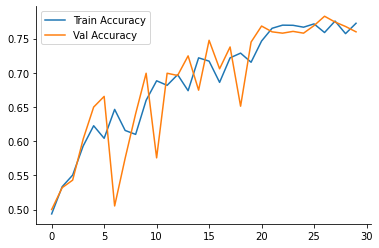

In [18]:
fig, ax = plt.subplots()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

ax.plot(epochs, acc, label='Train Accuracy')
ax.plot(epochs, val_acc, label='Val Accuracy')

ax.legend()
sns.despine()
plt.savefig("/content/drive/MyDrive/colab/train_val_accuracy_1123.png", dpi = 400, facecolor = "w", bbox_inches="tight");

In [20]:
model.save("/content/drive/MyDrive/colab/model_cnn_1123.h5")

In [19]:
import pandas as pd
pd.read_csv('training.log', sep=',', engine='python').to_csv('/content/drive/MyDrive/colab/training_log_1122.csv')